In [1]:
from imports import *
from cat_plotting_tools import *

import pyneb as pn

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Get the new HST catalogue 
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
inputfile = '%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations_fixediso_10pc.fits' %root_dir
outputfile = '%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wassociations_wprops_fixediso_10pc.fits' %root_dir

# Read table
table = QTable.read(inputfile)

# Get the Barnes et al. 2021 catalogue
table_b21 = QTable.read('/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master.fits') 
for key in table_b21.keys():
    if key == 'region_ID' or key == 'gal_name':
        continue
    table_b21.rename_column(key, key+'_MUSE_B21')
table_all = join(table, table_b21, keys=['region_ID', 'gal_name'])

# Get the full muse catalogue
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table_muse = QTable.read('%s/data_misc/Nebulae_catalogue_v4/Nebulae_catalogue_v4.fits' %root_dir) 

In [3]:
table

gal_name,region_ID,x_max,y_max,x_com,y_com,ra_max,dec_max,ra_com,dec_com,npix,HA6562_FLUX_HST,HA6562_FLUX_ERR_HST,area_exact,radius_circ,flux_max,flux_min,flux_mean,radius_circ_pc,x_mom,y_mom,ra_mom,dec_mom,area_ellipse,major_sigma,minor_sigma,mean_sigma,position_angle,mean_sigma_pc,complexity_score,complexity_score_leaves,complexity_rms,complexity_std,flag_edge_hst,EW_HA6562_raw_MUSE,EW_HA6562_raw_ERR_MUSE,EW_HB4861_raw_MUSE,EW_HB4861_raw_ERR_MUSE,EW_HA6562_fit_MUSE,EW_HA6562_fit_ERR_MUSE,EW_HB4861_fit_MUSE,EW_HB4861_fit_ERR_MUSE,EW_HA6562_bgcorr_MUSE,EW_HA6562_bgcorr_ERR_MUSE,EW_HB4861_bgcorr_MUSE,EW_HB4861_bgcorr_ERR_MUSE,HA6562_FLUX_CORR_HST,HA6562_FLUX_ERR_CORR_HST,HA6562_LUMINOSITY_HST,HA6562_LUMINOSITY_ERR_HST,region_circ_rad_pc_MUSE,flag_touch_hst,region_ID_association_v_08pc,ra_association_v_08pc,dec_association_v_08pc,area_association_v_08pc,rad_association_v_08pc,age_association_v_08pc,age_err_association_v_08pc,mass_association_v_08pc,mass_err_association_v_08pc,ebv_association_v_08pc,ebv_err_association_v_08pc,age_ave_association_v_08pc,mass_sum_association_v_08pc,no_associations_association_v_08pc,one_associations_association_v_08pc,multiple_associations_association_v_08pc,region_ID_association_v_16pc,ra_association_v_16pc,dec_association_v_16pc,area_association_v_16pc,rad_association_v_16pc,age_association_v_16pc,age_err_association_v_16pc,mass_association_v_16pc,mass_err_association_v_16pc,ebv_association_v_16pc,ebv_err_association_v_16pc,age_ave_association_v_16pc,mass_sum_association_v_16pc,no_associations_association_v_16pc,one_associations_association_v_16pc,multiple_associations_association_v_16pc,region_ID_association_v_32pc,ra_association_v_32pc,dec_association_v_32pc,area_association_v_32pc,rad_association_v_32pc,age_association_v_32pc,age_err_association_v_32pc,mass_association_v_32pc,mass_err_association_v_32pc,ebv_association_v_32pc,ebv_err_association_v_32pc,age_ave_association_v_32pc,mass_sum_association_v_32pc,no_associations_association_v_32pc,one_associations_association_v_32pc,multiple_associations_association_v_32pc,region_ID_association_v_64pc,ra_association_v_64pc,dec_association_v_64pc,area_association_v_64pc,rad_association_v_64pc,age_association_v_64pc,age_err_association_v_64pc,mass_association_v_64pc,mass_err_association_v_64pc,ebv_association_v_64pc,ebv_err_association_v_64pc,age_ave_association_v_64pc,mass_sum_association_v_64pc,no_associations_association_v_64pc,one_associations_association_v_64pc,multiple_associations_association_v_64pc,region_ID_association_nuv_08pc,ra_association_nuv_08pc,dec_association_nuv_08pc,area_association_nuv_08pc,rad_association_nuv_08pc,age_association_nuv_08pc,age_err_association_nuv_08pc,mass_association_nuv_08pc,mass_err_association_nuv_08pc,ebv_association_nuv_08pc,ebv_err_association_nuv_08pc,age_ave_association_nuv_08pc,mass_sum_association_nuv_08pc,no_associations_association_nuv_08pc,one_associations_association_nuv_08pc,multiple_associations_association_nuv_08pc,region_ID_association_nuv_16pc,ra_association_nuv_16pc,dec_association_nuv_16pc,area_association_nuv_16pc,rad_association_nuv_16pc,age_association_nuv_16pc,age_err_association_nuv_16pc,mass_association_nuv_16pc,mass_err_association_nuv_16pc,ebv_association_nuv_16pc,ebv_err_association_nuv_16pc,age_ave_association_nuv_16pc,mass_sum_association_nuv_16pc,no_associations_association_nuv_16pc,one_associations_association_nuv_16pc,multiple_associations_association_nuv_16pc,region_ID_association_nuv_32pc,ra_association_nuv_32pc,dec_association_nuv_32pc,area_association_nuv_32pc,rad_association_nuv_32pc,age_association_nuv_32pc,age_err_association_nuv_32pc,mass_association_nuv_32pc,mass_err_association_nuv_32pc,ebv_association_nuv_32pc,ebv_err_association_nuv_32pc,age_ave_association_nuv_32pc,mass_sum_association_nuv_32pc,no_associations_association_nuv_32pc,one_associations_association_nuv_32pc,multiple_associations_association_nuv_32pc,region_ID_association_nuv_64pc,ra_association_nuv_64pc,dec

# GET ELECTRON DENSITY

In [4]:
# Function to produce the SII ratio limit vs. temperature function using pyneb... 
# This slightly differs from the one in the Barnes et al. 2021 paper... 
def get_sii_ratio_ll_func(sii_array = np.linspace(1.39, 1.51, 200), t_array = np.linspace(5000, 20000, 10), showplot=False):

    from scipy.interpolate import CubicSpline

    sii_max = np.empty(len(t_array))
    S2 = pn.Atom('S', 2)
    
    for i, t in enumerate(t_array):
        ne = S2.getTemDen(sii_array, tem=t, wave1=6716, wave2=6730)
        if showplot:
            plt.plot(sii_array, ne, label='%0.0f K' %t)
            plt.legend()
        mask = np.where(ne == 1)[0][0]
        sii_max[i] = sii_array[mask]  

    spl = CubicSpline(t_array, sii_max)

    return(spl)

rerun = False
if rerun:
    sii_ratio_ll_func = get_sii_ratio_ll_func()
    cat_misc.save_pickle(sii_ratio_ll_func, './tmp/sii_ratio_ll_func.pkl')
else: 
    sii_ratio_ll_func = cat_misc.load_pickle('./tmp/sii_ratio_ll_func.pkl')

[INFO] [load_pickle] Load ./tmp/sii_ratio_ll_func.pkl


Error correction factor [SII]: 1.522


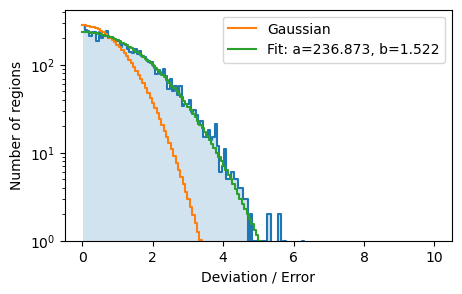

In [5]:
def get_SIIerror_correction_factor(table_muse, sii_ratio_ll_func, showplot=False):

    # Simple Gaussian function
    def func(x, a, b):
        return a * np.exp(-0.5 * x**2 / b**2)

    # Get SII error correction factor from all MUSE data (need for statistics)

    sii1 = table_muse['SII6716_FLUX'].value
    sii2 = table_muse['SII6730_FLUX'].value
    sii1_err = table_muse['SII6716_FLUX_ERR'].value
    sii2_err = table_muse['SII6730_FLUX_ERR'].value
    t_n2 = table_muse['TEM_NII'].value
    t_n2[t_n2.mask] = 8000 

    isHII = table_muse['HII_class_v3'] == 1
    mask = (sii1 > 0) & (sii2 > 0) & isHII

    sii_ratio = sii1 / sii2
    sii_ratio_err = sii_ratio * np.sqrt((sii1_err / sii1)**2 + (sii2_err / sii2)**2)
    sii_ratio_ll = sii_ratio_ll_func(t_n2)
    # sii_ratio_ll = 1.48922887 - 3.94351016e-6 * t_n2 # Don't know where this comes from... 
    # sii_ratio_ll = 1.4484 # Sanders et al (2016, ApJ, 816, 23)

    sii_ratio_lldiff = sii_ratio - sii_ratio_ll 
    sii_ratio_lldifferr = sii_ratio_lldiff / sii_ratio_err

    sii_ratio = sii_ratio[mask]
    sii_ratio_err = sii_ratio_err[mask]
    sii_ratio_lldiff = sii_ratio_lldiff[mask]
    sii_ratio_lldifferr = sii_ratio_lldifferr[mask]

    bins = np.linspace(0, 10, 150)
    bins1, bins_cent1, hist1 = get_hist(sii_ratio_lldifferr[sii_ratio_lldifferr >= 0], bins=bins, norm=False)
    popt, pcov = curve_fit(func, bins_cent1, hist1, p0=[np.nanmax(hist1), 1])

    if showplot:

        fig = plt.figure(figsize=(5, 3))
        ax = fig.add_subplot(111)
        ax.plot(bins_cent1, hist1, ds='steps-mid')
        ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

        ax.plot(bins, func(bins, np.nanmax(hist1), 1), ds='steps-mid', label='Gaussian')

        ax.set_yscale('log')
        ax.set_ylim(1.0, np.nanmax(hist1)*1.5)

        ax.plot(bins, func(bins, *popt), ds='steps-mid', label='Fit: a=%5.3f, b=%5.3f' %tuple(popt))

        ax.legend()

        ax.set_xlabel("Deviation / Error")
        ax.set_ylabel("Number of regions")

    error_factor = popt[1]
    print('Error correction factor [SII]: %0.3f' %error_factor)

    return error_factor

error_factor = get_SIIerror_correction_factor(table_muse, sii_ratio_ll_func, showplot=True)

In [6]:
def get_ne_from_SII(table, error_factor, sii_ratio_ll_func):

    sii1 = table['SII6716_FLUX_MUSE'].value
    sii2 = table['SII6730_FLUX_MUSE'].value
    sii1_corr = table['SII6716_FLUX_CORR_MUSE'].value 
    sii2_corr = table['SII6730_FLUX_CORR_MUSE'].value 

    sii1_err = table['SII6716_FLUX_ERR_MUSE'].value * error_factor
    sii2_err = table['SII6730_FLUX_ERR_MUSE'].value * error_factor
    sii1_corr_err = table['SII6716_FLUX_CORR_ERR_MUSE'].value * error_factor
    sii2_corr_err = table['SII6730_FLUX_CORR_ERR_MUSE'].value * error_factor

    t_n2 = table['TEM_NII_MUSE'].value
    t_n2[t_n2.mask] = 8000 

    isHII = table['HII_class_v3_MUSE'] == True
    mask = (sii1 > 0) & (sii2 > 0) & isHII

    sii_ratio = sii1 / sii2
    sii_corr_ratio = sii1_corr/sii2_corr

    sii_ratio_err = sii_ratio * np.sqrt((sii1_err / sii1)**2 + (sii2_err / sii2)**2)
    sii_ratio_ll = sii_ratio_ll_func(t_n2)

    mask1 = (sii_ratio > 0) 
    mask2 = (sii_ratio < sii_ratio_ll - (3*sii_ratio_err))
    mask_tot = ((mask1) & (mask2) & (mask))

    S2 = pn.Atom('S', 2)
    ne = S2.getTemDen(sii_corr_ratio, tem=t_n2, wave1=6716, wave2=6730) # Corrected fluxes here... 
    # ne_noncorr = S2.getTemDen(sii_ratio, tem=t_n2, wave1=6716, wave2=6730) # Not corrected fluxes here (just to check)... 

    ne = ne *u.cm**-3
    ne[~mask_tot] = np.nan
    
    return ne

table['ne'] = get_ne_from_SII(table, error_factor, sii_ratio_ll_func)

# GET IONISATION RATE and Rstrom

In [7]:
def get_reccoeff(temp):
    alpha = 2.753e-14 * (315614 /  temp)**1.500 / ((1.0 + (115188 / temp)**0.407)**2.242)
    return(alpha*u.cm**3/u.s)

def get_rstrom(Q, rec_coeff, ne):
    r_strom = ((3/(4*np.pi)) * (Q/(rec_coeff*ne**2)))**(1/3)
    return(r_strom.to('pc'))

def get_nstrom(Q, rec_coeff, r):
    n_strom = ((3/(4*np.pi)) * (Q/(rec_coeff*r**3)))**(1/2)
    return(n_strom.to('1/cm^3'))

radius_circ_pc = table['radius_circ_pc']
radius_mom_pc = table['mean_sigma_pc']
radius_circ_muse = table['region_circ_rad_pc_MUSE']

ha_lum = table['HA6562_LUMINOSITY_HST']
t_n2 = table['TEM_NII_MUSE'].value
t_n2[t_n2.mask] = 8000 

ha_photon_energy = (1.89 *u.eV).to('erg')   # Energy in erg of single H-alpha photon (https://en.wikipedia.org/wiki/Balmer_series)
ha_rate = ha_lum / ha_photon_energy         # Emission rate (in photons per s) of H-alpha
Q = ha_rate / 0.45                          # Per Calzetti (2012), ~45% of recombinations result in emission of an H-alpha photon

rec_coeff = get_reccoeff(t_n2) # Recombination 
radius_strom_pc = get_rstrom(Q, rec_coeff, table['ne']) # Stromgren Radius

ne_strom_circ = get_nstrom(Q, rec_coeff, radius_circ_pc) # Stromgren Density - Circ HST
ne_strom_mom = get_nstrom(Q, rec_coeff, radius_mom_pc)  # Stromgren Density - Mom HST
ne_strom_circ_muse = get_nstrom(Q, rec_coeff, radius_circ_muse) # Stromgren Density - Circ MUSE

table['rec_coeff'] = rec_coeff
table['Q'] = Q
table['radius_strom_pc'] = radius_strom_pc
table['ne_strom_circ'] = ne_strom_circ
table['ne_strom_mom'] = ne_strom_mom
table['ne_strom_circ_muse'] = ne_strom_circ_muse

In [8]:
table.write(outputfile, overwrite=True)

In [9]:
table

gal_name,region_ID,x_max,y_max,x_com,y_com,ra_max,dec_max,ra_com,dec_com,npix,HA6562_FLUX_HST,HA6562_FLUX_ERR_HST,area_exact,radius_circ,flux_max,flux_min,flux_mean,radius_circ_pc,x_mom,y_mom,ra_mom,dec_mom,area_ellipse,major_sigma,minor_sigma,mean_sigma,position_angle,mean_sigma_pc,complexity_score,complexity_score_leaves,complexity_rms,complexity_std,flag_edge_hst,EW_HA6562_raw_MUSE,EW_HA6562_raw_ERR_MUSE,EW_HB4861_raw_MUSE,EW_HB4861_raw_ERR_MUSE,EW_HA6562_fit_MUSE,EW_HA6562_fit_ERR_MUSE,EW_HB4861_fit_MUSE,EW_HB4861_fit_ERR_MUSE,EW_HA6562_bgcorr_MUSE,EW_HA6562_bgcorr_ERR_MUSE,EW_HB4861_bgcorr_MUSE,EW_HB4861_bgcorr_ERR_MUSE,HA6562_FLUX_CORR_HST,HA6562_FLUX_ERR_CORR_HST,HA6562_LUMINOSITY_HST,HA6562_LUMINOSITY_ERR_HST,region_circ_rad_pc_MUSE,flag_touch_hst,region_ID_association_v_08pc,ra_association_v_08pc,dec_association_v_08pc,area_association_v_08pc,rad_association_v_08pc,age_association_v_08pc,age_err_association_v_08pc,mass_association_v_08pc,mass_err_association_v_08pc,ebv_association_v_08pc,ebv_err_association_v_08pc,age_ave_association_v_08pc,mass_sum_association_v_08pc,no_associations_association_v_08pc,one_associations_association_v_08pc,multiple_associations_association_v_08pc,region_ID_association_v_16pc,ra_association_v_16pc,dec_association_v_16pc,area_association_v_16pc,rad_association_v_16pc,age_association_v_16pc,age_err_association_v_16pc,mass_association_v_16pc,mass_err_association_v_16pc,ebv_association_v_16pc,ebv_err_association_v_16pc,age_ave_association_v_16pc,mass_sum_association_v_16pc,no_associations_association_v_16pc,one_associations_association_v_16pc,multiple_associations_association_v_16pc,region_ID_association_v_32pc,ra_association_v_32pc,dec_association_v_32pc,area_association_v_32pc,rad_association_v_32pc,age_association_v_32pc,age_err_association_v_32pc,mass_association_v_32pc,mass_err_association_v_32pc,ebv_association_v_32pc,ebv_err_association_v_32pc,age_ave_association_v_32pc,mass_sum_association_v_32pc,no_associations_association_v_32pc,one_associations_association_v_32pc,multiple_associations_association_v_32pc,region_ID_association_v_64pc,ra_association_v_64pc,dec_association_v_64pc,area_association_v_64pc,rad_association_v_64pc,age_association_v_64pc,age_err_association_v_64pc,mass_association_v_64pc,mass_err_association_v_64pc,ebv_association_v_64pc,ebv_err_association_v_64pc,age_ave_association_v_64pc,mass_sum_association_v_64pc,no_associations_association_v_64pc,one_associations_association_v_64pc,multiple_associations_association_v_64pc,region_ID_association_nuv_08pc,ra_association_nuv_08pc,dec_association_nuv_08pc,area_association_nuv_08pc,rad_association_nuv_08pc,age_association_nuv_08pc,age_err_association_nuv_08pc,mass_association_nuv_08pc,mass_err_association_nuv_08pc,ebv_association_nuv_08pc,ebv_err_association_nuv_08pc,age_ave_association_nuv_08pc,mass_sum_association_nuv_08pc,no_associations_association_nuv_08pc,one_associations_association_nuv_08pc,multiple_associations_association_nuv_08pc,region_ID_association_nuv_16pc,ra_association_nuv_16pc,dec_association_nuv_16pc,area_association_nuv_16pc,rad_association_nuv_16pc,age_association_nuv_16pc,age_err_association_nuv_16pc,mass_association_nuv_16pc,mass_err_association_nuv_16pc,ebv_association_nuv_16pc,ebv_err_association_nuv_16pc,age_ave_association_nuv_16pc,mass_sum_association_nuv_16pc,no_associations_association_nuv_16pc,one_associations_association_nuv_16pc,multiple_associations_association_nuv_16pc,region_ID_association_nuv_32pc,ra_association_nuv_32pc,dec_association_nuv_32pc,area_association_nuv_32pc,rad_association_nuv_32pc,age_association_nuv_32pc,age_err_association_nuv_32pc,mass_association_nuv_32pc,mass_err_association_nuv_32pc,ebv_association_nuv_32pc,ebv_err_association_nuv_32pc,age_ave_association_nuv_32pc,mass_sum_association_nuv_32pc,no_associations_association_nuv_32pc,one_associations_association_nuv_32pc,multiple_associations_association_nuv_32pc,region_ID_association_nuv_64pc,ra_association_nuv_64pc,dec